In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.layers import Input, Conv2D, Reshape, UpSampling2D, MaxPool2D, Dense, Flatten
from keras.layers import Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [2]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
K.set_session(session)

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test,  (len(x_test),  28, 28, 1))

y_train_cat = to_categorical(y_train).astype(np.float32)
y_test_cat  = to_categorical(y_test).astype(np.float32)

In [4]:
batch_size = 500
latent_dim = 2
dropout_rate = 0.3
start_lr = 0.0001
num_classes = 10

In [5]:
from keras.layers import RepeatVector, Reshape, concatenate


def add_units_to_conv2d(conv2, units):
    dim1 = int(conv2.shape[1])
    dim2 = int(conv2.shape[2])
    dimc = int(units.shape[1])
    repeat_n = dim1 * dim2
    units_repeat = RepeatVector(repeat_n)(units)
    units_repeat = Reshape((dim1, dim2, dimc))(units_repeat)
    return concatenate([conv2, units_repeat])

In [6]:
from keras.layers import Lambda


input_cvae_encoder = Input(shape=(28, 28, 1))
input_cvae_encoder_lbl = Input(shape=(num_classes,), dtype='float32')

with tf.variable_scope("cvae_encoder"):
    x = Conv2D(32, kernel_size=(5, 5))(input_cvae_encoder)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = LeakyReLU()(x)    
    x = Dropout(dropout_rate)(x)
    x = add_units_to_conv2d(x, input_cvae_encoder_lbl)

    x = Conv2D(16, kernel_size=(5, 5))(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = LeakyReLU()(x)    
    x = Dropout(dropout_rate)(x)

    begin_of_dense = Flatten()(x)
    x = Dense(latent_dim * 40)(begin_of_dense)
    x = LeakyReLU()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(latent_dim * 20)(begin_of_dense)
    x = LeakyReLU()(x)
    x = Dropout(dropout_rate)(x)

    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    
cvae_encoder = Model([input_cvae_encoder, input_cvae_encoder_lbl], l, name="Encoder")
cvae_encoder_mean = Model([input_cvae_encoder, input_cvae_encoder_lbl], z_mean, name="ZMeaner")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [7]:
input_cvae_decoder = Input(shape=(latent_dim,))
input_cvae_decoder_lbl = Input(shape=(num_classes,), dtype='float32')

with tf.variable_scope("cvae_decoder"):
    x = Dense(49)(input_cvae_decoder)
    x = Reshape(target_shape=(7, 7, 1))(x)

    x = Conv2D(16, kernel_size=(7, 7), padding='same')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = LeakyReLU()(x)    
    x = Dropout(dropout_rate)(x)
    x = add_units_to_conv2d(x, input_cvae_decoder_lbl)    

    x = Conv2D(32, kernel_size=(5, 5), padding='same')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = LeakyReLU()(x)    
    x = Dropout(dropout_rate)(x)
    decoded = Conv2D(1, kernel_size=(7, 7), padding='same', activation='sigmoid')(x)

cvae_decoder = Model([input_cvae_decoder, input_cvae_decoder_lbl], decoded, name='Decoder')

In [8]:
from keras.objectives import binary_crossentropy


def cvae_loss(x, decoded):
    x = K.reshape(x, shape=(batch_size, 28 * 28))
    decoded = K.reshape(decoded, shape=(batch_size, 28 * 28))
    xent_loss = 28 * 28 * binary_crossentropy(x, decoded)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return (xent_loss + kl_loss) / 2 / 28 / 28

In [9]:
from keras.optimizers import Adam


cvae_model = Model(inputs=[input_cvae_encoder, input_cvae_encoder_lbl, input_cvae_decoder_lbl],
                   outputs=cvae_decoder([cvae_encoder([input_cvae_encoder, input_cvae_encoder_lbl]), input_cvae_decoder_lbl]),
                   name="ConvCVAE")
cvae_model.compile(loss=cvae_loss, optimizer=Adam(start_lr))
cvae_model.summary()

Model: "ConvCVAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
Encoder (Model)                 (None, 2)            28092       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 10)           0                                     

In [10]:
session.run(tf.global_variables_initializer())

In [11]:
digit_size = 28
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    plt.figure(figsize=(2 * n, 2 * len(args)))
    plt.imshow(figure, cmap='Greys_r')
    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

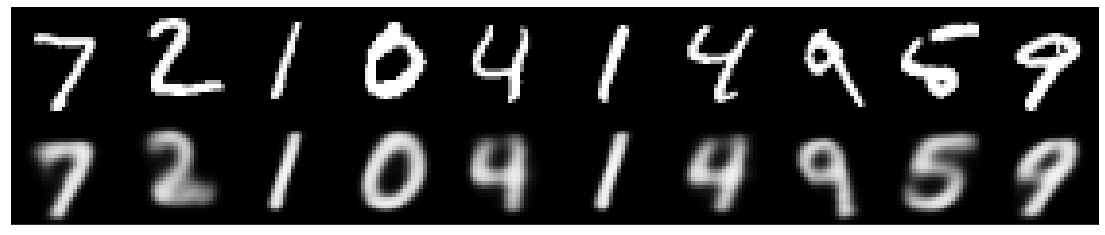

Epoch 197/200
60000/60000 [==============================] - 16s 260us/step - loss: 0.0940 - val_loss: 0.0892
Epoch 198/200
60000/60000 [==============================] - 16s 261us/step - loss: 0.0940 - val_loss: 0.0891
Epoch 199/200
60000/60000 [==============================] - 16s 261us/step - loss: 0.0940 - val_loss: 0.0890
Epoch 200/200
60000/60000 [==============================] - 16s 261us/step - loss: 0.0940 - val_loss: 0.0892
ALL TRAINING TIME: 3147.5185163021088


In [13]:
import time

from IPython.display import clear_output
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard


latent_distrs = [[] for x in range(num_classes)]
epochs = []
# epochs_to_check = np.linspace(1, 101, num=20).astype('int')
# epochs_to_check = [i for i in range(201)]
epochs_to_check = np.arange(0., 200.0, 5.0).astype('int')

imgs = x_test[:batch_size]
imgs_lbls = y_test_cat[:batch_size]
n_compare = 10


def on_epoch_end(epoch, logs):
    if epoch in epochs_to_check:
        clear_output()
        
        decoded = cvae_model.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])
        
        for lbl in range(num_classes):
            idxs = y_test == lbl
            z_predicted = cvae_encoder_mean.predict([x_test[idxs], y_test_cat[idxs]], batch_size=batch_size)
            latent_distrs[lbl].append(z_predicted)
        epochs.append(epoch)


pltfig = LambdaCallback(on_epoch_end=on_epoch_end)
tb     = TensorBoard(log_dir='./logs')


start_time = time.time()
cvae_model.fit([x_train, y_train_cat, y_train_cat], x_train,
               shuffle=True,
               epochs=200,
               batch_size=batch_size,
               validation_data=([x_test, y_test_cat, y_test_cat], x_test),
               callbacks=[pltfig, tb],
               verbose=1)
print(f"ALL TRAINING TIME: %s" % (time.time() - start_time))

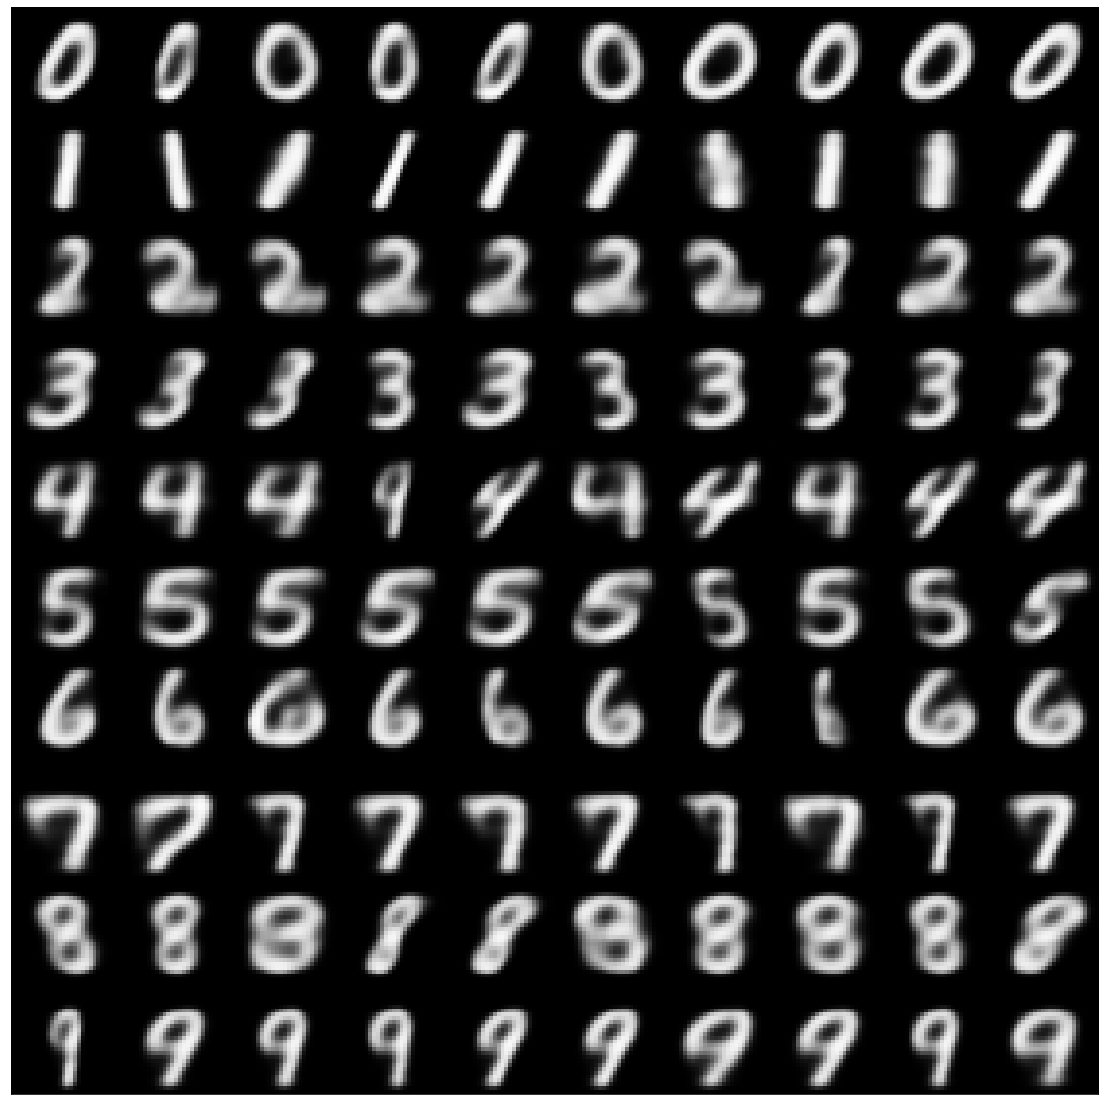

In [14]:
to_compare = []
for lbl in range(num_classes):
    codes = np.random.normal(size=(batch_size, latent_dim))
    lbls = np.zeros(shape=(batch_size, num_classes))
    lbls[:, lbl] = 1

    predicted = cvae_decoder.predict([codes, lbls], batch_size=batch_size)
    to_compare.append(predicted[:n_compare])
plot_digits(*to_compare)

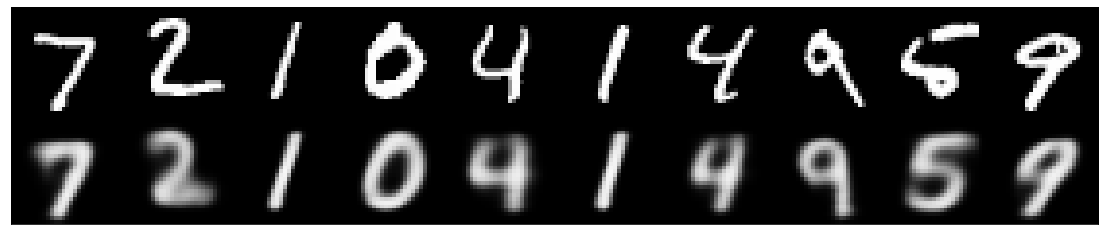

In [15]:
decoded = cvae_model.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
plot_digits(imgs[:n_compare], decoded[:n_compare])

In [16]:
import os
import json

save_path = os.path.join("saved_models", "convolutional_cvae")
if not os.path.exists(save_path):
    os.mkdir(save_path)

with open(os.path.join(save_path, "cvae_2_ldim_200_epochs.json"), "w") as f:
    json.dump(cvae_model.to_json(), f, indent=4)
cvae_model.save_weights(os.path.join(save_path, "cvae_2_ldim_200_epochs.h5"))

with open(os.path.join(save_path, "cvae_encoder_2_ldim_200_epochs.json"), "w") as f:
    json.dump(cvae_encoder.to_json(), f, indent=4)
cvae_encoder.save_weights(os.path.join(save_path, "cvae_encoder_2_ldim_200_epochs.h5"))

with open(os.path.join(save_path, "cvae_decoder_2_ldim_200_epochs.json"), "w") as f:
    json.dump(cvae_decoder.to_json(), f, indent=4)
cvae_decoder.save_weights(os.path.join(save_path, "cvae_decoder_2_ldim_200_epochs.h5"))

# Draw the manifold

In [17]:
import matplotlib
from matplotlib.animation import FuncAnimation
from matplotlib import cm


def make_2d_scatter_gif(fname, fig):
    plt.title("MANIFOLD\nEpoch: {}".format(epochs[0]))
    for lbl in range(num_classes):
        im = plt.scatter(latent_distrs[lbl][0][:, 0], latent_distrs[lbl][0][:, 1], label=str(lbl))
    plt.legend(loc='upper right')

    def update(i):
        fig.clear()
        for lbl in range(num_classes):
            im = plt.scatter(latent_distrs[lbl][i][:, 0], latent_distrs[lbl][i][:, 1], label=str(lbl))
        im.axes.set_title("MANIFOLD\nEpoch: {}".format(epochs[i]))
        im.axes.set_xlim(-5, 5)
        im.axes.set_ylim(-5, 5)
        plt.legend(loc='upper right')

        return im
    
    min_len = min([len(latent_distrs[lbl]) for lbl in range(num_classes)])
    writer = matplotlib.animation.HTMLWriter()
    anim = FuncAnimation(fig, update, frames=range(min_len), interval=100)
    anim.save(fname, dpi=80, writer="imagemagick")

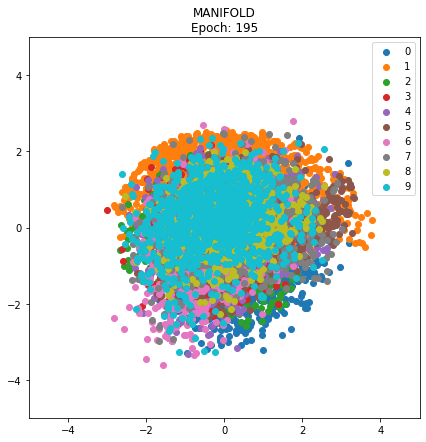

In [18]:
import os


gif_file_path = "./figs4/z_distr_conv_cvae_2_ldim_200_epochs.gif"
if not os.path.exists(os.path.dirname(gif_file_path)):
    os.mkdir(os.path.dirname(gif_file_path))
    
make_2d_scatter_gif(gif_file_path, plt.figure(figsize=(7,7)))

In [19]:
%load_ext tensorboard

In [21]:
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 3504), started 1:22:33 ago. (Use '!kill 3504' to kill it.)

# BUILDING GAN

In [ ]:
batch_size = 64

def gen_batch(x, y):
    n_batches = x.shape[0] // batch_size
    while (True):
        idxs = np.random.permutation(y.shape[0])
        x = x[idxs]
        y = y[idxs]
        for i in range(n_batches):
            yield x[batch_size * i:batch_size * (i + 1)], y[batch_size * i:batch_size * (i + 1)]

train_batches_it = gen_batch(x_train, y_train_cat)
test_batches_it = gen_batch(x_test, y_test_cat)

In [ ]:
x_ = tf.placeholder(tf.float32, shape=(None, 28, 28, 1), name='image')
y_ = tf.placeholder(tf.float32, shape=(None, num_classes), name='labels')
z_ = tf.placeholder(tf.float32, shape=(None, latent_dim), name='z')

img = Input(tensor=x_)
lbl = Input(tensor=y_)
z = Input(tensor=z_)

In [ ]:
with tf.variable_scope('discrim'):
    x = Conv2D(128, kernel_size=(7, 7), strides=(2, 2), padding='same')(img)
    x = add_units_to_conv2d(x, lbl)
    x = LeakyReLU()(x)
    x = Dropout(dropout_rate)(x)
    x = MaxPool2D((2, 2), padding='same')(x)

    l = Conv2D(128, kernel_size=(3, 3), padding='same')(x)
    x = LeakyReLU()(l)
    x = Dropout(dropout_rate)(x)

    h = Flatten()(x)
    d = Dense(1, activation='sigmoid')(h)
discrim = Model([img, lbl], d, name="Discriminator")

In [ ]:
generated_z = cvae_decoder([z, lbl])
discr_img = discrim([img, lbl])
discr_gen_z = discrim([generated_z, lbl])

gan_model = Model([z, lbl], discr_gen_z, name="GAN")
gan = gan_model([z, lbl])

In [ ]:
log_dis_img = tf.reduce_mean(-tf.log(discr_img + 1e-10))
log_dis_gen_z = tf.reduce_mean(-tf.log(1. - discr_gen_z + 1e-10))

L_gen = -log_dis_gen_z
L_dis = 0.5 * (log_dis_gen_z + log_dis_img)

In [ ]:
optimizer_gen = tf.train.RMSPropOptimizer(0.0003)
optimizer_dis = tf.train.RMSPropOptimizer(0.0001)

generator_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'cvae_decoder')
discrim_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discrim')

step_gen = optimizer_gen.minimize(L_gen, var_list=generator_vars)
step_dis = optimizer_dis.minimize(L_dis, var_list=discrim_vars)

In [ ]:
session.run(tf.global_variables_initializer())

In [ ]:
# After tf.global_variables_initializer() the decoder_model is null
# We need to load weights from file
cvae_decoder.load_weights(os.path.join(save_path, "cvae_decoder_10dim.h5"))

In [ ]:
def step(image, label, zp):
    l_dis, _ = session.run([L_dis, step_gen], feed_dict={z:zp, lbl:label, img:image, K.learning_phase():1})
    return l_dis

def step_d(image, label, zp):
    l_dis, _ = session.run([L_dis, step_dis], feed_dict={z:zp, lbl:label, img:image, K.learning_phase():1})
    return l_dis

In [ ]:
import numpy


periods_to_check = np.arange(0., 6000.0, 50.0).astype('int')


def on_n_period():
    to_compare = []
    for lbl in range(num_classes):
        codes = np.random.normal(size=(batch_size, latent_dim))
        lbls = np.zeros(shape=(batch_size, num_classes))
        lbls[:, lbl] = 1

        predicted = cvae_decoder.predict([codes, lbls], batch_size=batch_size)
        to_compare.append(predicted[:n_compare])
    plot_digits(*to_compare)

In [ ]:
k_step = 5
periods_to_train = 6000

for period in range(periods_to_train):
    print('.', end='')

    b0, b1 = next(train_batches_it)
    zp = numpy.random.randn(batch_size, latent_dim)
    for j in range(k_step):
        l_d = step_d(b0, b1, zp)
        b0, b1 = next(train_batches_it)
        zp = numpy.random.randn(batch_size, latent_dim)
        if l_d < 1.0:
            break

    for j in range(k_step):
        l_d = step(b0, b1, zp)
        if l_d > 0.4:
            break
        b0, b1 = next(train_batches_it)
        zp = numpy.random.randn(batch_size, latent_dim)

    print("l_d: {}".format(l_d))
    if period in periods_to_check:
        print("Period: {}".format(period))
        on_n_period()

In [ ]:
to_compare = []
for lbl in range(num_classes):
    codes = np.random.normal(size=(batch_size, latent_dim))
    lbls = np.zeros(shape=(batch_size, num_classes))
    lbls[:, lbl] = 1

    predicted = cvae_decoder.predict([codes, lbls], batch_size=batch_size)
    to_compare.append(predicted[:n_compare])
plot_digits(*to_compare)

# TRY EASY GAN ARCHITECTURE

In [ ]:
# # After tf.global_variables_initializer() the decoder_model is null
# # We need to load weights from file
# cvae_decoder.load_weights(os.path.join(save_path, "cvae_decoder_2dim.h5"))

In [ ]:
# import tensorflow as tf
# from keras.layers import Dropout, BatchNormalization, Reshape, Flatten
# from keras.layers import Dense, Input, concatenate
# from keras.layers.advanced_activations import LeakyReLU
# from keras.models import Model
# from keras.optimizers import Adam


# input_discrim_img = Input(shape=(28, 28, 1))
# flatten_discrim_img = Flatten()(input_discrim_img)
# input_lbl = Input(shape=(num_classes,), dtype='float32')

# x = concatenate([flatten_discrim_img, input_lbl])
# x = Dense(1024)(x)
# x = LeakyReLU()(x)
# x = Dropout(dropout_rate)(x)

# x = Dense(512)(x)
# x = LeakyReLU()(x)
# x = Dropout(dropout_rate)(x)

# x = Dense(256)(x)
# x = LeakyReLU()(x)
# x = Dropout(dropout_rate)(x)

# x = Dense(1, activation='sigmoid')(x)

# discriminator_model = Model([input_discrim_img, input_lbl], x, name="Discriminator")
# discriminator_model.compile(loss='binary_crossentropy', optimizer=Adam())
# discriminator_model.summary()

In [ ]:
# discriminator_model.trainable = False

# gan_input_code = Input(shape=(latent_dim,))
# gan_input_lbl = Input(shape=(num_classes,))

# fake_image = cvae_decoder([gan_input_code, gan_input_lbl])

# gan_output = discriminator_model([fake_image, gan_input_lbl])

# gan = Model([gan_input_code, gan_input_lbl], gan_output, name="GAN with decoder")
# gan.compile(loss='binary_crossentropy', optimizer=Adam())
# gan.summary()

In [ ]:
# import time
# import numpy


# imgs = x_test[:batch_size]
# imgs_lbls = y_test_cat[:batch_size]
# n_compare = 10

# epochs = 200
# batch_size = 100
# steps_per_epoch = 600
# epochs_to_check = numpy.arange(0., 200.0, 10.0).astype('int')


# def gen_batch(x, y):
#     n_batches = x.shape[0] // batch_size
#     while (True):
#         idxs = np.random.permutation(y.shape[0])
#         x = x[idxs]
#         y = y[idxs]
#         for i in range(n_batches):
#             yield x[batch_size * i:batch_size * (i + 1)], y[batch_size * i:batch_size * (i + 1)]

# train_batches_it = gen_batch(x_train, y_train_cat)
# test_batches_it = gen_batch(x_test, y_test_cat)


# print(f'START TRAINING...')
# start_time = time.time()
# for epoch in range(epochs):
#     start_epoch_time = time.time()
#     for batch in range(steps_per_epoch):
#         b0, b1 = next(train_batches_it)
#         noise = numpy.random.randn(batch_size, latent_dim)

#         fake_x = cvae_decoder.predict([noise, b1])

#         x1 = numpy.concatenate((b0, fake_x))
#         x2 = numpy.concatenate((b1, b1))

#         disc_y = numpy.zeros(2 * batch_size)
#         disc_y[:batch_size] = 0.9

#         d_loss = discriminator_model.train_on_batch([x1, x2], disc_y)

#         gen_y = numpy.ones(batch_size)
#         g_loss = gan.train_on_batch([noise, b1], gen_y)

#     print(f'Epoch: %s Discriminator Loss: %s \t Generator Loss: %s \t Elapsed time for epoch: %s' % (epoch, d_loss, g_loss, time.time() - start_epoch_time))
    
#     if epoch in epochs_to_check:
#         b0, b1 = next(test_batches_it)
#         noise = numpy.random.randn(batch_size, latent_dim)

#         decoded = cvae_decoder.predict([noise, b1], batch_size=batch_size)
#         plot_digits(b0[:n_compare], decoded[:n_compare])

# print(f'\nELAPSED TIME FOR ALL TRAINING: %s' % (time.time() - start_time))